In [181]:
import pickle
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
import itertools
import edge_nn
import seaborn as sns
import networkx as nx

In [ ]:
#TODO properly quote the paper here

In [298]:
# Loading output files from paper's code

embbeding_file = 'dumps/test.d100_f100x100_g32_embeddings.npy.best'
trails_file = 'dumps/test.d100_f100x100_g32_trails.best'
net_file = 'dumps/test.d100_f100x100_g32_net.pkl.best'
index_file = 'dumps/index.pkl'

In [302]:
best_embbeding = np.load(embbeding_file)
trails = np.load(trails_file, allow_pickle=True)
net_values = dict(pickle.load(tf.gfile.Open(net_file, 'rb')))
node_index = np.load(index_file, allow_pickle=True)['index']

In [56]:
best_embbeding

array([[ 0.16091563,  0.14932607,  0.04858583, ...,  0.10608763,
        -0.13409753, -0.04937138],
       [ 0.01464372, -0.12907113, -0.09973747, ..., -0.16875201,
        -0.12758446,  0.07178327],
       [ 0.18134284, -0.11540475,  0.11188345, ...,  0.10143788,
         0.05555671,  0.03057978],
       ...,
       [-0.14194305,  0.08575352,  0.03692203, ..., -0.02374582,
         0.05971862,  0.07670918],
       [-0.11017483, -0.13583584,  0.07460093, ...,  0.02638273,
        -0.07436947,  0.12653415],
       [ 0.06784367,  0.10301112, -0.02112932, ..., -0.07132531,
        -0.1536294 , -0.08823059]], dtype=float32)

In [5]:
# Load the neural network to predict edge likelihood
tf.compat.v1.disable_eager_execution()

# Create the edge Neural Network.
NN = edge_nn.EdgeNN()
NN.build_net(
  embedding_dim=100, dnn_dims='100,100',
  projection_dim=32,
  num_projections=1)

SESS = tf.Session()
SESS.run(tf.global_variables_initializer())

ALL_VARS = tf.global_variables()
for v in ALL_VARS:
  if v.name in net_values:
    SESS.run(v.assign(net_values[v.name]))

c:\program files\python39\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [249]:
# Create combination of all posible edges
nodes = [x for x in range(0,len(best_embbeding))]
all_edges = np.array(list(itertools.combinations(nodes, 2)))
all_edges

array([[   0,    1],
       [   0,    2],
       [   0,    3],
       ...,
       [1646, 1647],
       [1646, 1648],
       [1647, 1648]])

In [250]:
len(all_edges)

1358776

In [251]:
# Use neural networ to get edge likelihood
grads_and_objective = SESS.run(
    NN.output,
    feed_dict={
      NN.embeddings_a: best_embbeding[all_edges[:, 0]],
      NN.embeddings_b: best_embbeding[all_edges[:, 1]],
      NN.batch_size: len(all_edges),
    })
#print(mov,1/(1+np.exp(-grads_and_objective[0])))
grads_and_objective

array([-3.6637492,  1.5751424, -5.480854 , ..., -3.3449123, -3.3366463,
       -2.425726 ], dtype=float32)

In [252]:
# Transform results into a dataframe

total_edges = pd.DataFrame()

total_edges['from'] = all_edges[:, 0]
total_edges['to'] = all_edges[:, 1]
#Likelihood transformed into standard logistic, acording to equation 8 in the paper
total_edges['likelihood'] = 1/(1+np.exp(-grads_and_objective))
total_edges

,from,to,likelihood
0,0,1,0.024995
1,0,2,0.828515
2,0,3,0.004148
3,0,4,0.004611
4,0,5,0.170338
...,...,...,...
1358771,1645,1647,0.000985
1358772,1645,1648,0.018415
1358773,1646,1647,0.034062
1358774,1646,1648,0.034335


In [253]:
# Loading edges from train/test files
# This is done to preserve the node naming convention used while training the NN

# File names
train_edges_file = 'dumps/train.txt.npy'
test_edges_file = 'dumps/test.txt.npy'
# Arrays of edges
train_edges = np.load(train_edges_file)
test_edges = np.load(test_edges_file)
# Concatenate all
existing_edges = np.concatenate((train_edges,test_edges), axis=0)

# Convert the above into a dataframe
actual_edges = pd.DataFrame(existing_edges)
actual_edges = actual_edges.rename(columns={0:'first',1:'second'})
actual_edges['from'] = actual_edges[['first','second']].min(axis=1)
actual_edges['to'] = actual_edges[['first','second']].max(axis=1)
actual_edges['exists'] = 1
actual_edges = actual_edges[['from','to','exists']]
actual_edges

,from,to,exists
0,0,23,1
1,0,1616,1
2,0,330,1
3,0,1386,1
4,0,777,1
...,...,...,...
7603,1372,1519,1
7604,901,1265,1
7605,770,1190,1
7606,872,895,1


In [307]:
# Trying to get the remapping from the source file!

# Load edgelist
edge_list = pd.read_csv('datasets/dancer_01/dancer_01.txt', sep=' ', header=None)
edge_list = edge_list.rename(columns={0:'from',1:'to'})
mapped_edges = []

node_id = 0
for index, row in edge_list.iterrows():  
    if node_index[str(row['from'])] < node_index[str(row['to'])]:
        mapped_edges.append([node_index[str(row['from'])],node_index[str(row['to'])]])
    else:
        mapped_edges.append([node_index[str(row['to'])],node_index[str(row['from'])]])
        
other_actual_edges = pd.DataFrame(mapped_edges)
other_actual_edges = other_actual_edges.drop_duplicates()
other_actual_edges = other_actual_edges.rename(columns={0:'from',1:'to'})

In [308]:
other_actual_edges[other_actual_edges['from'] == 0]

,from,to
0,0,23
1,0,1616
2,0,21
3,0,330
4,0,1386
5,0,537
6,0,875
7,0,66
8,0,1454
9,0,777


In [309]:
actual_edges[actual_edges['from'] == 0]

,from,to,exists
0,0,23,1
1,0,1616,1
2,0,330,1
3,0,1386,1
4,0,777,1
5,0,904,1
6,0,1313,1
7,0,2,1
8,0,1136,1
9,0,106,1


In [284]:
# UNUSED
# First approach for trying the above, but it doesn't mantain the node naming

# Load graph
graph = nx.Graph()
graph = nx.read_edgelist('datasets/dancer_01/dancer_01.txt', create_using=graph)

# From this create value-index pair
mapping = {}
for index, value in enumerate(graph.nodes):
    mapping[value] = index

# From this create edge list
other_actual_edges = []
for e_from, e_to in graph.edges:
    other_actual_edges.append([e_from,e_to])
    print(e_from,e_to)
    print(mapping[e_from],mapping[e_to])
    break
    #other_actual_edges.append([mapping[e_from],mapping[e_to]])
    
# Convert the above into a dataframe
#other_actual_edges = pd.DataFrame(other_actual_edges)
#other_actual_edges = other_actual_edges.rename(columns={0:'first',1:'second'})
#other_actual_edges['from'] = other_actual_edges[['first','second']].min(axis=1)
#other_actual_edges['to'] = other_actual_edges[['first','second']].max(axis=1)
#other_actual_edges['exists'] = 1
#other_actual_edges = other_actual_edges[['from','to','exists']]
#other_actual_edges

0 102
0 1


In [289]:
list(graph.edges)[0]
list(graph.nodes)[1]

'102'

In [254]:
# Join total posible edges with the actual ones to compare existance with likelihood
merged = pd.merge(total_edges, actual_edges,  how='left', left_on=['from','to'], right_on = ['from','to'])
merged = merged.fillna(0)
merged

,from,to,likelihood,exists
0,0,1,0.024995,0.0
1,0,2,0.828515,1.0
2,0,3,0.004148,0.0
3,0,4,0.004611,0.0
4,0,5,0.170338,0.0
...,...,...,...,...
1358771,1645,1647,0.000985,0.0
1358772,1645,1648,0.018415,0.0
1358773,1646,1647,0.034062,0.0
1358774,1646,1648,0.034335,0.0


<AxesSubplot:xlabel='likelihood', ylabel='Count'>

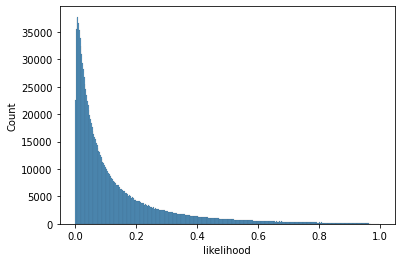

In [255]:
#Histogram of all
sns.histplot(data=merged, x="likelihood")

<AxesSubplot:xlabel='likelihood', ylabel='Count'>

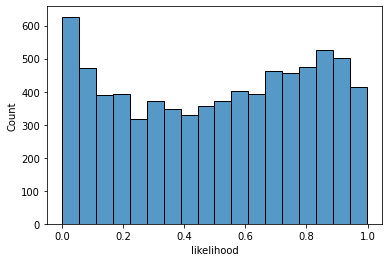

In [256]:
#Histogram of existing edges
sns.histplot(data=merged[merged['exists']==1], x="likelihood")

<AxesSubplot:xlabel='likelihood', ylabel='Count'>

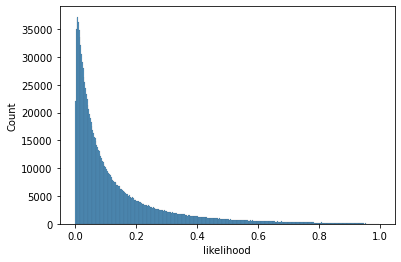

In [257]:
#Histogram of unexisting edges
sns.histplot(data=merged[merged['exists']==0], x="likelihood")